In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# загружаем данные
# каталог с исходными данными
folder_path = 'D:/Документы/Programs/DataFile/Проект 4/'

credit = pd.read_csv(f"{folder_path}train_2.csv", encoding = 'ISO-8859-1', low_memory = False)
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


In [18]:
credit.head(7)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,M,62,Y,Y,0,0,1,1,2,18000,N,0
1,63161,SCH,F,59,N,N,0,0,3,2,3,19000,N,0
2,25887,SCH,M,25,Y,N,2,0,1,1,2,30000,Y,0
3,16222,SCH,F,53,N,N,0,0,2,2,3,10000,N,0
4,101655,GRD,M,48,N,N,0,1,1,2,3,30000,Y,0
5,41415,SCH,M,27,Y,N,0,1,0,1,1,15000,N,0
6,28436,SCH,M,39,N,N,0,0,0,1,2,28000,N,0


Известно содержание следующих полей:

* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заёмщика
* age - возраст заёмщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля-иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия «хорошей» работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заёмщика
* foreign_passport - наличие загранпаспорта
* default - наличие дефолта

In [19]:
# посомтрим содержание нечисловых полей
object_columns = [s for s in credit.columns if credit[s].dtypes == 'object']
for i in object_columns:
    print(f'Содержимое поля {i}:\n{credit[i].value_counts()}\n')

Содержимое поля education:
SCH    38860
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64

Содержимое поля sex:
F    41562
M    32237
Name: sex, dtype: int64

Содержимое поля car:
N    49832
Y    23967
Name: car, dtype: int64

Содержимое поля car_type:
N    59791
Y    14008
Name: car_type, dtype: int64

Содержимое поля foreign_passport:
N    62733
Y    11066
Name: foreign_passport, dtype: int64



In [20]:
# бинарные параметры (содержащие всего два значения) заменим на числовые, используя LabelEncoder
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport']

label_encoder = LabelEncoder()

for column in bin_cols:
    credit.loc[:,[column]] = label_encoder.fit_transform(credit[column])
    
# убедимся в преобразовании    
credit.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,1,62,1,1,0,0,1,1,2,18000,0,0
1,63161,SCH,0,59,0,0,0,0,3,2,3,19000,0,0
2,25887,SCH,1,25,1,0,2,0,1,1,2,30000,1,0
3,16222,SCH,0,53,0,0,0,0,2,2,3,10000,0,0
4,101655,GRD,1,48,0,0,0,1,1,2,3,30000,1,0


# построение упрощенной модели

In [21]:
# судя по info только education содержит пропуски
# для построение упрощенной модели удалим записи с пропусками
credit_easy = credit.dropna()
credit_easy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73492 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73492 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73492 non-null  int32 
 3   age               73492 non-null  int64 
 4   car               73492 non-null  int32 
 5   car_type          73492 non-null  int32 
 6   decline_app_cnt   73492 non-null  int64 
 7   good_work         73492 non-null  int64 
 8   bki_request_cnt   73492 non-null  int64 
 9   home_address      73492 non-null  int64 
 10  work_address      73492 non-null  int64 
 11  income            73492 non-null  int64 
 12  foreign_passport  73492 non-null  int32 
 13  default           73492 non-null  int64 
dtypes: int32(4), int64(9), object(1)
memory usage: 7.3+ MB


D:\MyProg\Programm\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


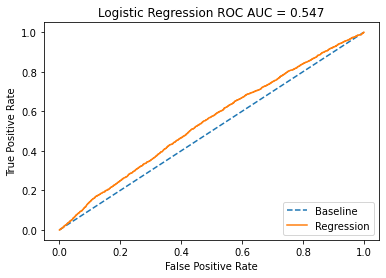

Confusion matrix:
 [[12822     0]
 [ 1877     0]]


In [22]:
# посмотрим результат обучение упрощенной модели без преобразования данных
# нечисловые поля предварительно удалим
object_columns = [s for s in credit_easy.columns if credit_easy[s].dtypes == 'object']
credit_easy.drop(object_columns, axis = 1, inplace=True)

# Разделим данные для обучения
X = credit_easy.drop(['default'], axis=1)
Y = credit_easy['default']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# обучаем модель на обучающих данных
model = LogisticRegression()
model.fit(X_train, y_train)

# В качестве методов оценки прогностической способности модели используем ROC-анализ и confusion_matrix
pr_probs = model.predict_proba(X_test)[:,1]

fpr, tpr, threshold = roc_curve(y_test, pr_probs)
roc_auc = roc_auc_score(y_test, pr_probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Выводим confusion_matrix
probs = model.predict(X_test)

conf_mat = confusion_matrix(y_test, probs)
print(f'Confusion matrix:\n {conf_mat}')

## получается несбалансированная модель, которая совсем не предсказывает default

In [23]:
# дополнительные метрики это подтверждают
acc = accuracy_score(y_test, probs)
f1 = f1_score(y_test, probs)
print(f'acc = {acc:.3f} F1-score = {f1:.3f}')

acc = 0.872 F1-score = 0.000


# производим более тщательную предобработку данных

In [24]:
# создадим отдельный признак отсутствия данных об образовании
credit['education_isnan'] = (credit['education'].isna()).astype('uint8')
# находим наиболее частый признак образования
ed_max = credit.education.value_counts().index[0]
# заполняем наиболее частым значением пропуски
credit.education.fillna(ed_max, inplace=True)
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73799 non-null  object
 2   sex               73799 non-null  int32 
 3   age               73799 non-null  int64 
 4   car               73799 non-null  int32 
 5   car_type          73799 non-null  int32 
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  int32 
 13  default           73799 non-null  int64 
 14  education_isnan   73799 non-null  uint8 
dtypes: int32(4), int64(9), object(1), uint8(1)
memory usage: 6.8+ MB


# преобразуем оставшейся категориальный параметр

In [25]:
# преобразуем уровень образования в dummies переменные
credit = pd.get_dummies(credit, columns=['education'], prefix='education', dtype="uint8")
credit.head(7)

,client_id,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default,education_isnan,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR
0,25905,1,62,1,1,0,0,1,1,2,18000,0,0,0,0,0,0,1,0
1,63161,0,59,0,0,0,0,3,2,3,19000,0,0,0,0,0,0,1,0
2,25887,1,25,1,0,2,0,1,1,2,30000,1,0,0,0,0,0,1,0
3,16222,0,53,0,0,0,0,2,2,3,10000,0,0,0,0,0,0,1,0
4,101655,1,48,0,0,0,1,1,2,3,30000,1,0,0,0,1,0,0,0
5,41415,1,27,1,0,0,1,0,1,1,15000,0,0,0,0,0,0,1,0
6,28436,1,39,0,0,0,0,0,1,2,28000,0,0,0,0,0,0,1,0


# стандартизируем числовые параметры с помощью StandardScaler

In [26]:
# выбираем все числовые параметры, которые были в датасете изначально
num_cols_all = [s for s in credit.columns if (credit[s].dtypes in ['int64', 'float64'])]
# и посмотрим на их уникальные значения
for i in num_cols_all:
    print(f'Содержимое поля {i}:\n{credit[i].value_counts()}\n')

Содержимое поля client_id:
6141     1
42113    1
29467    1
19228    1
21279    1
        ..
46588    1
48637    1
42494    1
87552    1
2049     1
Name: client_id, Length: 73799, dtype: int64

Содержимое поля age:
31    2727
28    2705
30    2693
29    2659
27    2645
26    2528
32    2501
34    2395
33    2314
35    2259
25    2202
36    2159
37    2118
38    2088
39    2082
42    1973
40    1932
24    1873
41    1857
43    1770
44    1690
23    1509
45    1487
50    1424
47    1418
46    1407
48    1404
52    1387
51    1385
53    1326
54    1326
49    1304
55    1230
56    1114
57    1040
22     937
59     925
58     881
60     851
21     849
61     661
62     576
63     477
64     449
65     422
66     309
67     248
68     165
69      81
70      32
71       3
72       2
Name: age, dtype: int64

Содержимое поля decline_app_cnt:
0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3

In [27]:
# стандартезируем числовые поля (кроме client_id) только с более 5 уникальными значениями 
num_cols = [s for s in credit.columns[1:] if ((credit[s].dtypes in ['int64', 'float64']) and credit[s].nunique() > 5)]
credit[num_cols] = StandardScaler().fit_transform(credit[num_cols].values)
credit.head(7)

,client_id,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default,education_isnan,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR
0,25905,1,1.972115,1,1,-0.342858,0,-0.444189,1,2,-0.500363,0,0,0,0,0,0,1,0
1,63161,0,1.711705,0,0,-0.342858,0,0.443888,2,3,-0.478702,0,0,0,0,0,0,1,0
2,25887,1,-1.239607,1,0,2.143880,0,-0.444189,1,2,-0.240432,1,0,0,0,0,0,1,0
3,16222,0,1.190886,0,0,-0.342858,0,-0.000150,2,3,-0.673651,0,0,0,0,0,0,1,0
4,101655,1,0.756869,0,0,-0.342858,1,-0.444189,2,3,-0.240432,1,0,0,0,1,0,0,0
5,41415,1,-1.066000,1,0,-0.342858,1,-0.888227,1,1,-0.565346,0,0,0,0,0,0,1,0
6,28436,1,-0.024361,0,0,-0.342858,0,-0.888227,1,2,-0.283754,0,0,0,0,0,0,1,0


# проверяем, нет ли мультиколлинеарности — сильной взаимосвязи между независимыми признаками

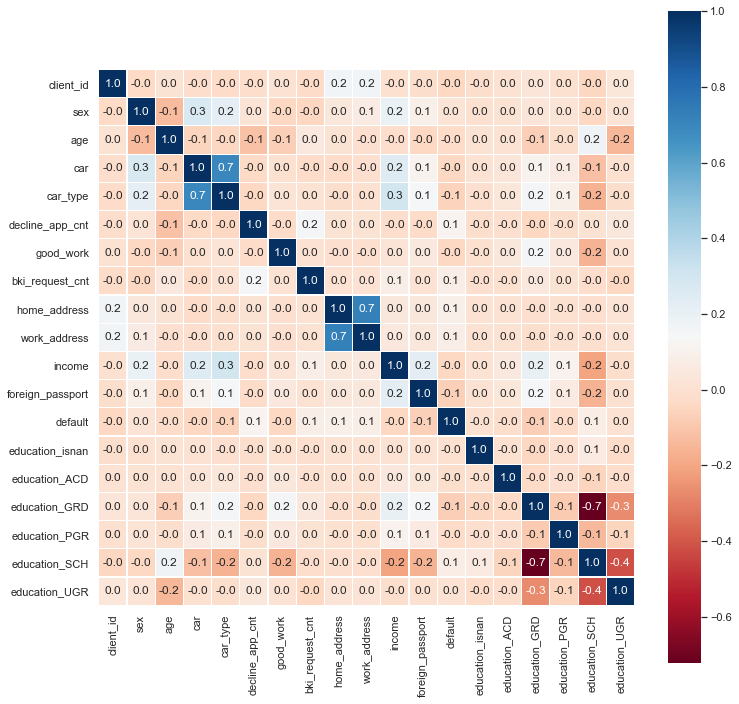

In [28]:
# для этого строим матрицу корреляций для признаков
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(credit.corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

# Оценка значимости переменных

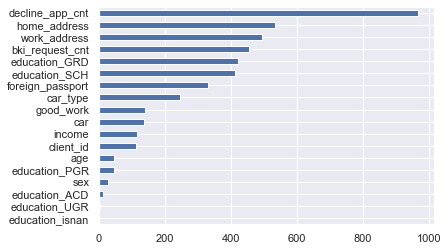

In [29]:
# в качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, 
# тем важнее данный признак для нашей линейной модели.
cols = credit.drop(['default'], axis=1).columns

imp_num = pd.Series(f_classif(credit[cols], credit['default'])[0], index=cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

# посмотрим результат обучение полученной модели

D:\MyProg\Programm\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


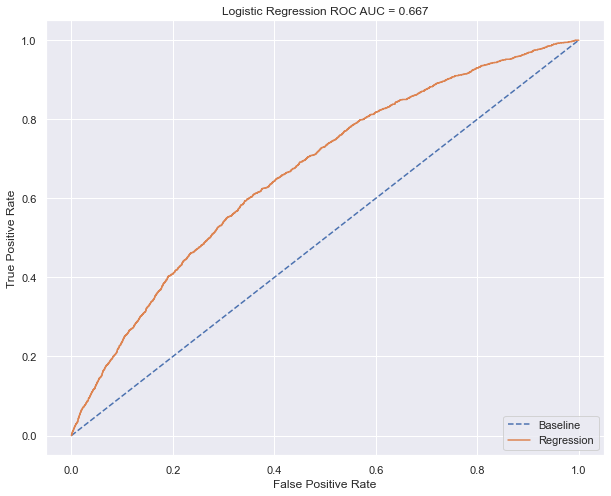

Confusion matrix:
 [[12908    25]
 [ 1811    16]]


In [30]:
# Разделим данные для обучения
X = credit.drop(['client_id', 'default'], axis=1)
Y = credit['default']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# обучаем модель на обучающих данных
model = LogisticRegression()
model.fit(X_train, y_train)

pr_probs = model.predict_proba(X_test)[:,1]

fpr, tpr, threshold = roc_curve(y_test, pr_probs)
roc_auc = roc_auc_score(y_test, pr_probs)

plt.rcParams['figure.figsize'] = (10,8)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

probs = model.predict(X_test)

conf_mat = confusion_matrix(y_test, probs)
print(f'Confusion matrix:\n {conf_mat}')

In [31]:
# дополнительные метрики
acc = accuracy_score(y_test, probs)
f1 = f1_score(y_test, probs)
print(f'acc = {acc:.3f} F1-score = {f1:.3f}')

acc = 0.876 F1-score = 0.017


## ROC AUC стала лучше, но другие метрики говорят о плохо сбалансированной модели

# Undersampling

In [32]:
# делаеv эту же выборку сбалансированной
# т.е. строки с самым большим количеством в классе (default = n_class.index[0]) оставляем в количесте,
# равном количеству строк (n_class[1]) в минимальном классе n_class.index[1]
# выбираем состав целевых классов
n_class = credit.default.value_counts()
# оставляем равное количество записей в каждом целевом классе
credit_us = credit.drop(labels=credit[credit.default ==
                              n_class.index[0]].iloc[n_class[1]:].index)
credit_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18744 entries, 0 to 73797
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         18744 non-null  int64  
 1   sex               18744 non-null  int32  
 2   age               18744 non-null  float64
 3   car               18744 non-null  int32  
 4   car_type          18744 non-null  int32  
 5   decline_app_cnt   18744 non-null  float64
 6   good_work         18744 non-null  int64  
 7   bki_request_cnt   18744 non-null  float64
 8   home_address      18744 non-null  int64  
 9   work_address      18744 non-null  int64  
 10  income            18744 non-null  float64
 11  foreign_passport  18744 non-null  int32  
 12  default           18744 non-null  int64  
 13  education_isnan   18744 non-null  uint8  
 14  education_ACD     18744 non-null  uint8  
 15  education_GRD     18744 non-null  uint8  
 16  education_PGR     18744 non-null  uint8 

# посмотрим результат обучение полученной модели

D:\MyProg\Programm\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


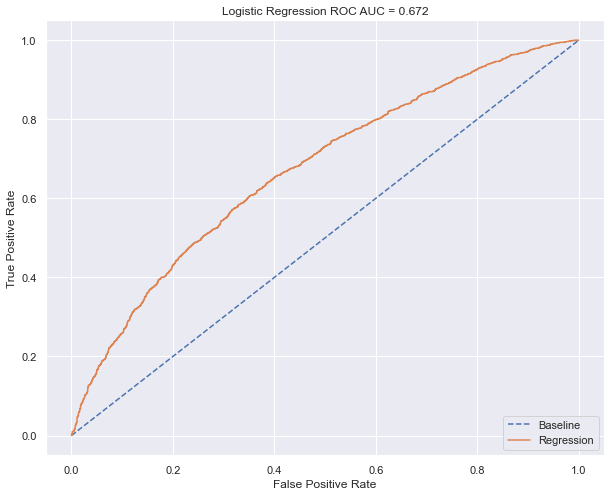

Confusion matrix:
 [[1165  740]
 [ 660 1184]]


In [33]:
# Разделим данные для обучения
X = credit_us.drop(['client_id', 'default'], axis=1)
Y = credit_us['default']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# обучаем модель на обучающих данных
model = LogisticRegression()
model.fit(X_train, y_train)

pr_probs = model.predict_proba(X_test)[:,1]

fpr, tpr, threshold = roc_curve(y_test, pr_probs)
roc_auc = roc_auc_score(y_test, pr_probs)

plt.rcParams['figure.figsize'] = (10,8)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

probs = model.predict(X_test)

conf_mat = confusion_matrix(y_test, probs)
print(f'Confusion matrix:\n {conf_mat}')

In [34]:
# дополнительные метрики
acc = accuracy_score(y_test, probs)
f1 = f1_score(y_test, probs)
print(f'acc = {acc:.3f} F1-score = {f1:.3f}')

acc = 0.627 F1-score = 0.628


## метрики стали гораздо лучше
## попробуем их еще улучшить

# Регуляризация

In [35]:
# найдем оптимальное значение параметра регуляризации для логистической регрессии
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# убрать предупреждения
import warnings
warnings.filterwarnings("ignore")

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

D:\MyProg\Programm\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\MyProg\Programm\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\MyProg\Programm\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\MyProg\Programm\Anaconda3\lib\site-packag

D:\MyProg\Programm\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\MyProg\Programm\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\MyProg\Programm\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\MyProg\Programm\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\MyProg\Programm\Anaconda3\lib\site-packages\sklear

Лучшее Penalty: l2
Лучшее C: 2.7825594022071245


## используем лучшие гиперпараметры

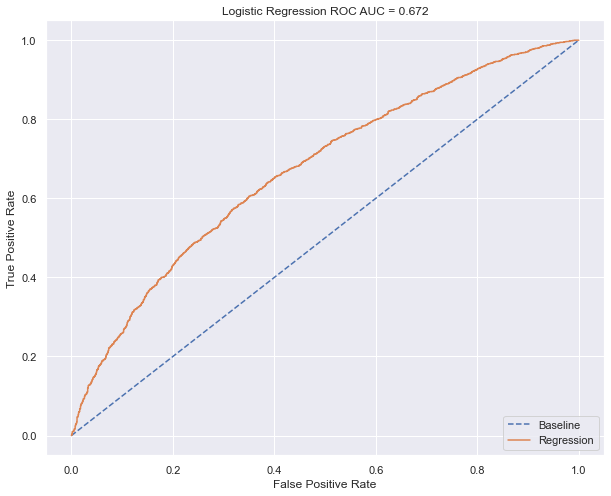

Confusion matrix:
 [[1165  740]
 [ 661 1183]]


In [36]:
# обучаем модель с найденными гиперпараметрами penalty, C
model = LogisticRegression(penalty='l2', C=2.7825594022071245)  # Обозначаем, что наша модель - логистическая регрессия с найденными гиперпараметрами
model.fit(X_train, y_train)  # обучаем модель на обучающих данных

pr_probs = model.predict_proba(X_test)[:,1]

fpr, tpr, threshold = roc_curve(y_test, pr_probs)
roc_auc = roc_auc_score(y_test, pr_probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

probs = model.predict(X_test)

conf_mat = confusion_matrix(y_test, probs)
print(f'Confusion matrix:\n {conf_mat}')

In [37]:
# дополнительные метрики
acc = accuracy_score(y_test, probs)
f1 = f1_score(y_test, probs)
print(f'acc = {acc:.3f} F1-score = {f1:.3f}')

acc = 0.626 F1-score = 0.628


# изменений почти нет, но и ухудшений не стало, поэтому оставляем найденные гиперпараметры для итоговой модели обучения